# North Carolina and Texas metamandering

In this notebook I want to build a  dual graph using vtd units for Texas and North Carolina, and then attempt to metamander these states by changing the histogram for the outcomes.

In [1]:
#general python tools
import csv
import os
from functools import partial
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from networkx import is_connected, connected_components
import sys
#gerry chain tools 
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
    GeographicPartition,
)
import maup as mp

nc_vtd_data Variable descriptions 

| VTD | County  | PL10AA_TOT | PL10VA_TOT | 
|---------|-----------|------|-----------|
|   VTD unique identifier  | County FIPS|Total population |Total voting age population |

In [2]:
tx_vtd_data = gpd.read_file("https://people.csail.mit.edu/ddeford/TX_vtds.zip")
nc_vtd_data = gpd.read_file("./data/North_Carolina/NC_VTD.shp")
tx_vtd_data.set_index("CNTYVTD", inplace=True)
tx_vtd_data['index'] = tx_vtd_data.index
nc_vtd_data.set_index("VTD", inplace=True)
nc_vtd_data['index'] = nc_vtd_data.index
states = {"tx":tx_vtd_data, "nc":nc_vtd_data}

In [3]:
tx_graph = Graph.from_geodataframe(tx_vtd_data)

GeometryError: Invalid geometries at rows ['2150011', '2950106', '3070401', '3990003', '4010416'] before reprojection. Consider repairing the affected geometries with `.buffer(0)`, or pass `ignore_errors=True` to attempt to create the graph anyways.

In [4]:
nc_graph = Graph.from_geodataframe(nc_vtd_data)

GeometryError: Invalid geometries at rows ['3702144.1', '3705722', '37163LAKE', '37179041', '37193108'] before reprojection. Consider repairing the affected geometries with `.buffer(0)`, or pass `ignore_errors=True` to attempt to create the graph anyways.

Need to fix graph issues

In [5]:
tx_problems = ['2150011', '2950106', '3070401', '3990003', '4010416']
nc_problems = ['3702144.1', '3705722', '37163LAKE', '37179041', '37193108']
problem_vtds_tx = tx_vtd_data['index'].isin(tx_problems)
problem_vtds_nc = nc_vtd_data['index'].isin(nc_problems)

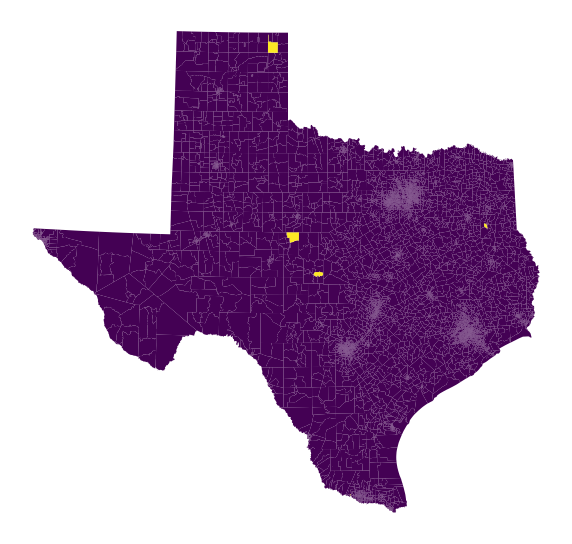

In [6]:
figsize = 10
tx_vtd_data.plot(column = problem_vtds_tx, figsize=(figsize, figsize))
plt.axis('off')
plt.show()

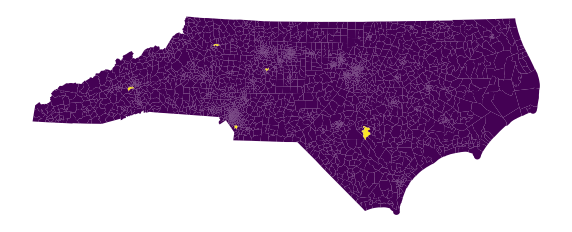

In [7]:
nc_vtd_data.plot(column = problem_vtds_nc, figsize=(figsize, figsize))
plt.axis('off')
plt.show()

CC Anthony: Some of the polygons self-intersect at a point (or nearly intersect at a point) or the boundaries of two polygons overlap too much. 

In [8]:
for problem in tx_problems:
    tx_vtd_data.loc[problem, "geometry"] = tx_vtd_data.loc[problem, "geometry"].buffer(0)
for problem in nc_problems:
    nc_vtd_data.loc[problem, "geometry"] = nc_vtd_data.loc[problem, "geometry"].buffer(0)

Lets see if building dual graph works now

In [9]:
tx_graph = Graph.from_geodataframe(tx_vtd_data)
nc_graph = Graph.from_geodataframe(nc_vtd_data)